# Exploration Data Analysis

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

In [2]:
# Import the data
recipes = pd.read_csv("../data/RAW_recipes.csv")
interactions = pd.read_csv("../data/RAW_interactions.csv")

In [3]:
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


## Analyse de l'activité des contributeurs

In [4]:
nb_contrib_users = interactions[["user_id"]].groupby(by="user_id").value_counts().sort_values(ascending=False)
nb_contrib_users.head(20)

user_id
424680     7671
37449      5603
383346     4628
169430     4076
128473     3917
89831      3353
58104      3288
133174     3107
199848     3018
305531     2902
226863     2874
4470       2739
498271     2644
369715     2610
1072593    2350
176615     2338
95743      2311
286566     2283
39835      2260
107583     2252
Name: count, dtype: int64

In [5]:
nb_contrib_users.value_counts()
recipes[recipes['contributor_id'] == 424680]
interactions[interactions['user_id'] == 424680]

,user_id,recipe_id,date,rating,review
149,424680,256416,2009-11-02,5,Made this with raw apple cider & my last bag o...
351,424680,408997,2011-10-18,5,Used Gala apples for these muffins & I was ver...
440,424680,426090,2010-05-29,5,Really enjoyed working with the mustard seeds ...
587,424680,175614,2008-06-09,5,"I cut back on the amount of red pepper, but ot..."
597,424680,383271,2009-08-31,5,Don't know if I changed the taste or texture o...
...,...,...,...,...,...
1131984,424680,289382,2008-05-02,5,I used cheese tortellini in this recipe & redu...
1132110,424680,116551,2011-08-07,5,"When it comes to smoothies, I don't usually li..."
1132175,424680,441819,2011-01-24,5,I was a little hesitant about making a recipe ...
1132319,424680,190261,2010-05-13,5,What a great way to dress up the ol' carrot! D...


# Analyse des ingrédients

L'objectif est de construire une typologie d'ingrédients, dont chaque classe constitue une feature sur les recettes (Nombre d'ingrédients appartenant à la classe présents dans la recette).

Les étapes sont les suivantes :
- extraction de l'ensemble des ingrédients
- nettoyage de l'ensemble des ingrédients
    - représentation des ingrédients par des embeddings
    - regroupement des ingrédients par proximité sémantiques
- classification des ingrédients

On extrait la liste des ingrédients et le nombre de fois où ils sont présents

In [165]:
import ast

ingredients = recipes['ingredients'].apply(ast.literal_eval).explode()
ingredients_count = ingredients.value_counts()
ingredients = pd.unique(ingredients)



On calcule les coordonnées des ingrédients dans les embeddings.

Le calcul se fait sur la base de la phrase "you can replace this ingredient with..." de façon à contextualiser le nom de l'ingrédient et d'assurer une proximité sémantique basée sur l'usage qu'on peut faire de l'ingrédient.

In [166]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-mpnet-base-v2")

# The sentences to encode
sentences = ingredients.astype(str)
sentences = sentences.tolist()

# 2. Calculate embeddings by calling model.encode()
embeddings = model.encode(sentences)
embeddings = pd.DataFrame(embeddings)
embeddings.set_index(ingredients)

# 3. Calculate the embedding similarities
# similarities = model.similarity(embeddings, embeddings)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
winter squash,-0.036591,-0.047101,-0.001833,0.039999,-0.006105,0.001905,-0.025866,0.017587,0.024039,0.023615,...,-0.029830,0.003152,-0.002424,-0.053350,0.027233,0.046287,-0.009533,0.016479,0.018149,-0.043170
mexican seasoning,-0.005203,0.017149,-0.026889,-0.043475,0.012014,0.044106,-0.094147,0.073447,-0.005792,0.017446,...,-0.074499,-0.023662,-0.047863,0.002818,0.032000,0.070354,-0.030363,0.010408,-0.057757,-0.010155
mixed spice,0.022124,-0.030244,-0.018320,-0.016123,0.010243,0.028720,-0.048018,0.028925,-0.008535,-0.034007,...,-0.010879,-0.012148,-0.047641,0.018081,0.011520,-0.022537,0.016161,0.009817,-0.057787,-0.050528
honey,0.005530,0.022562,0.021747,-0.051799,0.005717,0.016383,-0.028416,0.011698,0.063109,-0.016765,...,-0.035433,-0.005777,0.048864,-0.014553,0.030057,0.020633,0.000342,0.025127,-0.039036,-0.014290
butter,0.049180,0.046401,-0.013201,0.007080,0.024678,-0.011838,-0.065683,0.007737,0.038714,0.001840,...,-0.014908,-0.029666,-0.022830,0.013244,-0.000645,0.013715,0.019181,0.016195,-0.056000,-0.006470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
apricot jell-o,0.015011,0.025185,0.022729,-0.048400,-0.026283,-0.005772,-0.061799,0.030664,0.042690,0.028904,...,-0.050823,-0.002592,0.019391,-0.015090,0.012147,0.036770,0.047971,-0.006979,-0.019191,-0.016830
rosarita premium whole black beans,0.022637,0.012680,-0.027030,0.038627,0.030008,0.011227,-0.037924,0.047885,-0.010684,0.055236,...,-0.010811,0.038812,0.012899,0.009921,0.020606,-0.034558,-0.029491,0.002068,0.011022,0.006588
hunt's fire roasted diced tomatoes,-0.019031,0.063853,-0.019102,-0.052135,-0.016006,0.012324,0.000162,0.056936,-0.002073,-0.019391,...,-0.024287,-0.020470,-0.052286,-0.021415,-0.002831,0.047083,-0.022222,0.021978,-0.078327,-0.008611
skinless halibut fillet,-0.010163,0.033340,0.012540,-0.030905,-0.000645,0.018855,-0.008068,0.049910,0.021253,-0.006619,...,-0.025149,0.011677,0.007357,-0.011038,-0.005587,0.098393,-0.013146,-0.000937,-0.026506,0.010303


On réalise la CAH complète dans un premier temps (sans coupure de l'arbre) de façon à pouvoir déterminer un seuil pertinent ensuite

In [167]:
from sklearn.cluster import AgglomerativeClustering

# setting distance_threshold=0 ensures we compute the full tree.
# metric et linkage adaptés aux embeddings de phrases

cah = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric="cosine", linkage="average")
cah = cah.fit(embeddings)

ingredients_df = pd.DataFrame(ingredients)
ingredients_df['cluster'] = cah.labels_
ingredients_df.rename(columns = {0 : 'name'})


,name,cluster
0,winter squash,11690
1,mexican seasoning,8477
2,mixed spice,10993
3,honey,9909
4,butter,8558
...,...,...
14937,apricot jell-o,6
14938,rosarita premium whole black beans,2
14939,hunt's fire roasted diced tomatoes,4
14940,skinless halibut fillet,1


In [168]:
# Pour déterminer le seuil de coupure, on explicite la façon dont l'arbre regroupe les ingrédients à chaque étape 

def children_cleaning(cah):
    """Mise en forme de la table cah.children_ et adjonction des noms d'ingrédients"""
    linkage = pd.DataFrame(data = cah.children_).rename(columns={0:"left son", 1:"right son"})
    linkage['parent'] = linkage.index + len(linkage) + 1
    linkage['distance'] = cah.distances_
    linkage = pd.merge(linkage, ingredients_df, how='left', left_on="left son", right_index=True)
    linkage = pd.merge(linkage, ingredients_df, how="left", left_on="right son", right_index=True)
    linkage = linkage.rename(columns={"0_x":"ls name", "0_y":"rs name", "cluster_x":"ls cluster", "cluster_y":"rs cluster"})
    return linkage

linkage = children_cleaning(cah)


<Axes: >

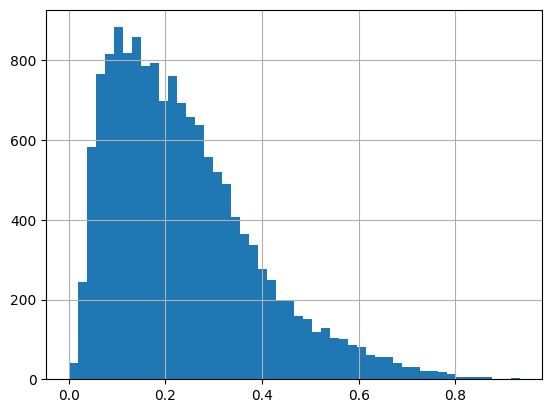

In [169]:
# Histogramme des distances
linkage.distance.hist(bins=50)

On peut proposer, avec le critère du coude, un seuil à 0.5. On se propose de vérifier empiriquement la pertinence du critère.

In [170]:
def cluster_labeling(data):
    """Chaque regroupement est étiqueté dans "parent name" par l'ingrédient le plus fréquent 
    (fréquence elle-même notée dans "parent freq")
    l'étiquette et la fréquence de l'ingrédient le plus fréquent dans chacun des deux fils sont également notés"""
    
    for i in range(len(data)):
        if not np.isnan(data.at[i, "rs cluster"]): # Si le fils droit est une feuille
            data.at[i, "rs cluster name"] = data.at[i, "rs name"]
            data.at[i, "rs freq"] = ingredients_count[data.at[i, "rs name"]]
        else: # Si le fils droit est un cluster, on en récupère le nom et la fréquence à la ligne où il a été défini comme parent
            data.at[i, "rs cluster name"] = data.loc[data["parent"] == data.at[i, "right son"], "parent name"].item()
            data.at[i, "rs freq"] = data.loc[data["parent"] == data.at[i, "right son"], "parent freq"].item()

        if not np.isnan(data.at[i, "ls cluster"]):
            data.at[i, "ls cluster name"] = data.at[i, "ls name"]
            data.at[i, "ls freq"] = ingredients_count[data.at[i, "ls name"]]
        else:
            data.at[i, "ls cluster name"] = data.loc[data["parent"] == data.at[i, "left son"], "parent name"].item()
            data.at[i, "ls freq"] = data.loc[data["parent"] == data.at[i, "left son"], "parent freq"].item()
        
        # Etiquetage du noeud parent par l'ingrédient le plus fréquent
        if data.at[i, "rs freq"] >= data.at[i, "ls freq"]:
            data.at[i, "parent name"] = data.at[i, "rs cluster name"]
            data.at[i, "parent freq"] = data.at[i, "rs freq"]
        else:
            data.at[i, "parent name"] = data.at[i, "ls cluster name"]
            data.at[i, "parent freq"] = data.at[i, "ls freq"]
    return data

linkage = cluster_labeling(linkage)


In [171]:
threshold = 0.50
linkage.loc[linkage['distance'] > 1.1 * threshold, ["distance", "ls cluster name", "rs cluster name"]].head(20)

,distance,ls cluster name,rs cluster name
14245,0.550088,bisquick,ready-made bruschetta
14246,0.550099,ribbon,cheesecloth
14247,0.550466,frozen blackberrie,frozen petits pois
14248,0.550868,jimmy dean breakfast skillets,morningstar farms meal starters grillers recip...
14249,0.551212,dried chamomile,chablis
14250,0.551248,angel food cake,icing sugar
14251,0.551285,cachaca,blue curacao
14252,0.551821,tea bags,tea
14253,0.552659,umeboshi vinegar,sake
14254,0.552759,low-calorie bread,bread


In [172]:
linkage.loc[linkage['distance'] < 0.9 * threshold, ["distance", "ls cluster name", "rs cluster name"]].tail(20)

,distance,ls cluster name,rs cluster name
13445,0.448202,heinz salad cream,heavy cream
13446,0.448416,seafood seasoning,poultry seasoning
13447,0.448427,mexican blend cheese,velveeta cheese
13448,0.448541,orange jell-o,unflavored gelatin
13449,0.448590,ground lamb,lamb backstraps
13450,0.448650,refrigerated biscuits,biscuit mix
13451,0.448719,accent seasoning,cajun seasoning
13452,0.448893,sloes,swede
13453,0.448903,ham knuckle,lamb shanks
13454,0.449209,salt,canning salt


In [173]:
model_cut = AgglomerativeClustering(distance_threshold=threshold, n_clusters=None, metric="cosine", linkage="average")
model_cut = model_cut.fit(embeddings)
print(model_cut.n_clusters_)

1023


In [176]:
ingredients_df = pd.DataFrame(ingredients)
ingredients_df['cluster'] = model_cut.labels_
ingredients_df = ingredients_df.rename(columns = {0 : 'name'})

# Etiquetage des clusters
temp = pd.merge(ingredients_df, ingredients_count, how="left", left_on="name", right_on="ingredients")
idx_max = temp.groupby("cluster")["count"].idxmax() # on récupère les index des ingrédients les plus fréquents par cluster
cluster_labels = temp.loc[idx_max, ["name", "cluster"]].rename(columns={"name" : "cluster label"})
ingredients_df = pd.merge(ingredients_df, cluster_labels, on="cluster")

<Axes: >

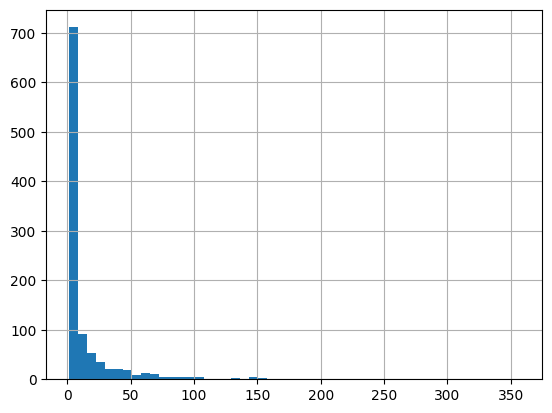

In [188]:
ingredients_df['cluster label'].value_counts().hist(bins=50)
# ingredients_df.loc[ingredients_df['cluster label'] == "semi-sweet chocolate chips", "name"]

In [189]:
temp = pd.DataFrame(recipes['ingredients'].apply(ast.literal_eval).explode())
temp["id_recipe"] = temp.index.to_list()
ingredients_df = pd.merge(temp, ingredients_df, left_on="ingredients", right_on="name")



In [190]:
ingredients_df['cluster label'].value_counts()

cluster label
salt             125331
pepper           104465
sugar             91055
olive oil         78881
onion             78344
                  ...  
garden trowel         1
terrapins             1
rumpleminze           1
cushaw                1
nepitella             1
Name: count, Length: 1023, dtype: int64

In [ ]:
cooc = np.zeros((len(cluster_labels), len(cluster_labels)), int)
index_map = {label: i for i, label in enumerate(cluster_labels["cluster label"])}

for recipe in range(len(recipes)):

    ings_recipe = ingredients_df.loc[ingredients_df["id_recipe"]==recipe, "cluster label"]

    for i, ing_recipe_h in enumerate(ings_recipe):
        for j, ing_recipe_v in enumerate(ings_recipe):
            cooc[index_map[ing_recipe_h], index_map[ing_recipe_v]] += 1

# cooc = cooc / cooc.sum(axis=0, keepdims=True)


In [139]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ACP sur la matrice coocurrence 
pca = PCA(n_components=6)
X_proj = pca.fit_transform(np.log1p(cooc))  

# X_proj = coordonnées des ingrédients dans le plan factoriel
coords = pd.DataFrame(X_proj, columns=['Dim1', 'Dim2', 'Dim3', 'Dim4', 'Dim5', 'Dim6'])

coords = pd.merge(coords, cluster_labels, left_index=True, right_on="cluster")

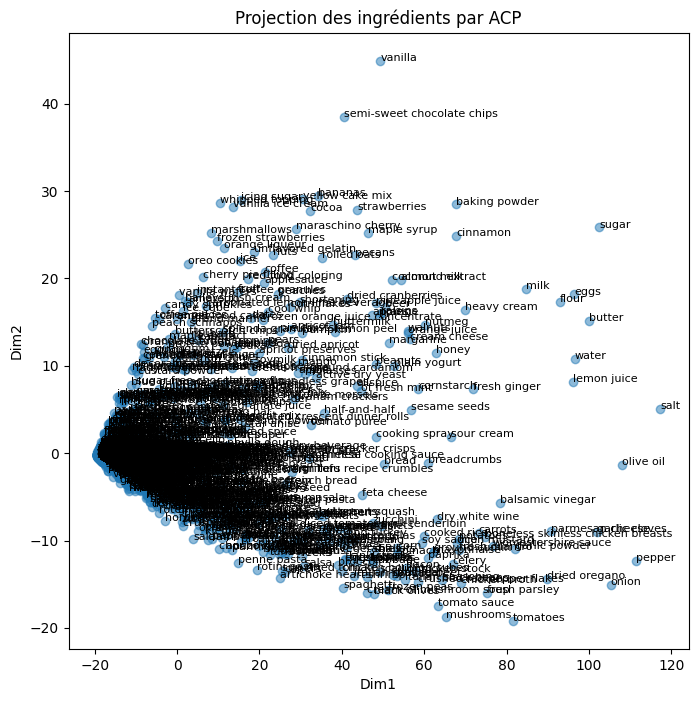

In [140]:
plt.figure(figsize=(8,8))
plt.scatter(coords['Dim1'], coords['Dim2'], alpha=0.5)

# si tu veux annoter les points
for i, row in coords.iterrows():
    plt.text(row['Dim1'], row['Dim2'], row['cluster label'], fontsize=8)

plt.xlabel("Dim1")
plt.ylabel("Dim2")
plt.title("Projection des ingrédients par ACP")
plt.show()

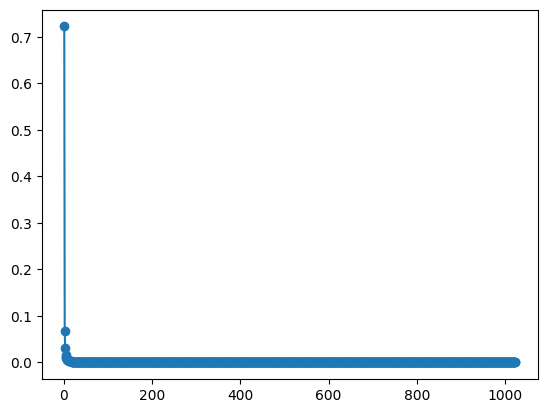

In [142]:
pca = PCA()
pca = pca.fit(np.log1p(cooc))



plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker="o") 
n_axes = np.sum(pca.explained_variance_ratio_ > 1/len(cluster_labels))


In [147]:
pca = PCA(n_components=n_axes)
X_proj = pca.fit_transform(np.log1p(cooc))
cah_clusters = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric="euclidean", linkage="ward")
cah_clusters = cah_clusters.fit(X_proj)

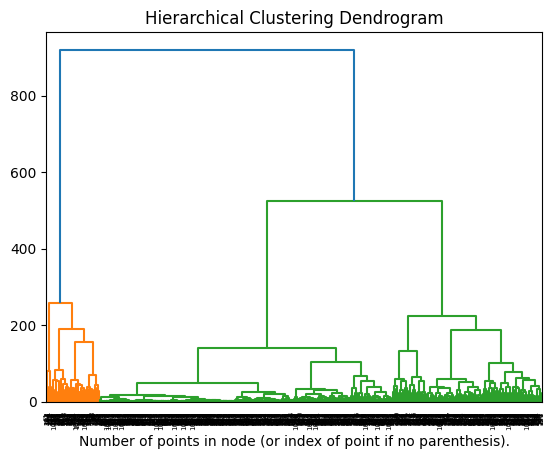

In [148]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(cah_clusters, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [163]:
model_cut = AgglomerativeClustering(distance_threshold=None, n_clusters=11, metric="euclidean", linkage="ward")
model_cut = model_cut.fit(np.log1p(cooc))
classif_finale = pd.DataFrame(model_cut.labels_)


In [164]:
pd.concat(
    [classif_finale.reset_index(drop=True), 
     cluster_labels.reset_index(drop=True)], 
    axis=1
)

,0,cluster label,cluster
0,4,pan juices,0
1,1,garlic cloves,1
2,0,icing sugar,2
3,6,apples,3
4,9,katakuriko,4
...,...,...,...
1018,6,sour cream,1018
1019,9,food-grade diatomaceous earth,1019
1020,9,honey comb,1020
1021,4,pig's feet,1021
